In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# We also need PrettyTensor.
import prettytensor as pt

In [3]:
os.chdir(r"D:\My Computer\DATA\Cats&Dogs")
train_data = np.load('train_data.npy')

In [4]:
print(type(train_data))
train_data[0:1]

<class 'numpy.ndarray'>


array([[ array([[255, 255, 255, ..., 255, 254, 254],
       [255, 255, 255, ..., 254, 254, 254],
       [255, 255, 255, ..., 254, 254, 254],
       ..., 
       [ 14,  48,  31, ..., 128,  98,  70],
       [ 10,  41,  42, ...,  90,  65,  25],
       [ 10,  35,  54, ...,  57,  28,  22]], dtype=uint8),
        array([1, 0])]], dtype=object)

In [5]:
print(len(train_data))

25000


In [6]:
x = [x[0] for x in train_data]
Y = [x[1] for x in train_data]
Y_cls= [x[0] for x in Y]

In [7]:
#Train
train_x = x[:20000]
train_Y = Y[:20000]
train_Y_cls = Y_cls[:20000]

#Test
test_x = x[20001:25000]
test_Y= Y[20001:25000]
test_Y_cls = Y_cls[20001:25000]

In [8]:
print(train_Y_cls[0])
print(train_x[0])
print(train_Y[0])

1
[[255 255 255 ..., 255 254 254]
 [255 255 255 ..., 254 254 254]
 [255 255 255 ..., 254 254 254]
 ..., 
 [ 14  48  31 ..., 128  98  70]
 [ 10  41  42 ...,  90  65  25]
 [ 10  35  54 ...,  57  28  22]]
[1 0]


In [7]:
print(type(test_x))
print(test_x[0])

<class 'list'>
[[ 49  43 110 ...,  63  60  56]
 [ 21  29  36 ...,  28  56  56]
 [ 34  29  42 ...,  16  45  54]
 ..., 
 [227 237 234 ...,  84  59  80]
 [230 236 234 ...,  87  69  76]
 [220 229 226 ...,  90  58  72]]


In [9]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 50

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 2

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [10]:
Y_cls= [x[0] for x in Y]

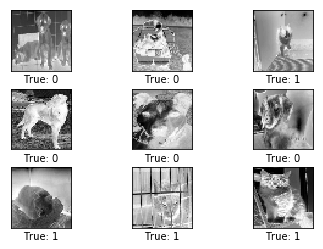

In [11]:
# Get the first images from the test-set.
images = x[10:19]

# Get the true classes for those images.
cls_true = Y_cls[10:19]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## PrettyTensor Graph

In [12]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [13]:
x_pretty = pt.wrap(x_image)

In [14]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

In [15]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [16]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [18]:
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Run

In [19]:
session = tf.Session()

In [20]:
session.run(tf.global_variables_initializer())

In [21]:
train_batch_size = 64

In [22]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = train_x.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [23]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_x[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = test_Y_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [24]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = test_Y_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [25]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(test_x)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = test_x[i:j, :]

        # Get the associated labels.
        labels = test_Y[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = test_Y_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [26]:
test_x[1]

array([[223, 220, 222, ...,  84,  84, 111],
       [222, 222, 223, ..., 102, 114, 111],
       [219, 222, 222, ..., 113, 109, 112],
       ..., 
       [ 86,  68,  96, ..., 207, 173, 177],
       [ 86,  69,  86, ..., 201, 153, 188],
       [ 67,  71,  67, ..., 163, 188, 181]], dtype=uint8)

In [29]:
print(test_x[1])
#test_x[1:2, :]

[[223 220 222 ...,  84  84 111]
 [222 222 223 ..., 102 114 111]
 [219 222 222 ..., 113 109 112]
 ..., 
 [ 86  68  96 ..., 207 173 177]
 [ 86  69  86 ..., 201 153 188]
 [ 67  71  67 ..., 163 188 181]]


In [27]:
print_test_accuracy()

TypeError: list indices must be integers or slices, not tuple